<a href="https://colab.research.google.com/github/ArooshJ/NNFromScratch/blob/main/BackPropAutoGrad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Networks and Backpropogation from scratch in Python
-Aroosh Joshi

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### The main Value, Neuron, Layer, Classes

In [ ]:
class Value:

    def __init__(self, value, name="val", requires_grad=True):
        self.data = value
        self.grad = 0
        '''
          Set parent.grad explicitly to 1  or the parent node when differentiating a parent node,
         else, all grads will be 0, if set to one here, childs gradient would also be 1,
         and actual grads will be accumulated on top of that (This is taken care in backwardpass function but not in individual backward)

        '''
        self.name = name
        self.requires_grad = requires_grad # For optimization purposes, not to calculate unnecessary gradients when not required, set it to false for such values.
        self.children = []
        self.backward = lambda: None

    def __add__(self, other):
        out = Value(self.data + other.data)
        out.name = f"{self.name} + {other.name}"
        out.children.append(self)
        out.children.append(other)
        def backward():
            self.grad += out.grad if self.requires_grad else 0 # Accumulation done as (for y = a + a,  grad(a) = dy/da = 2 (as y = 2a), but here, if we just assign it, self and other are both a and value 1 will be assgned to a twice, leading to final grad 1 of a/)
            other.grad += out.grad if other.requires_grad else 0
        out.backward = backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data)
        out.name = f"{self.name} * {other.name}"
        out.children.append(self)
        out.children.append(other)

        def backward():

            self.grad += other.data * out.grad if self.requires_grad else 0
           # print(f"self = {self}, self.grad = {self.grad}")
            other.grad += self.data * out.grad if other.requires_grad else 0
           # print(f"other = {other}, other.grad = {other.grad}")


        out.backward = backward
        return out

    def __sub__(self, other):
      # self - other
      out = Value(self.data - other.data)
      out.name = f"{self.name} - {other.name}"
      out.children.append(self)
      out.children.append(other)

      def backward():
          self.grad += out.grad if self.requires_grad  else 0 # (1*out.grad)
          other.grad += -out.grad  if other.requires_grad else 0 #(-1 * out.grad)

      out.backward = backward
      return out

    def __pow__(self, other):
      out = Value(self.data ** other.data)
      out.name = f"({self.name}) ** {other.name}"
      out.children.append(self)
      out.children.append(other)


      def backward():
        self.grad += other.data * (self.data **(other.data-1)) * out.grad  if self.requires_grad  else 0
        other.grad += (np.log(self.data) if self.data !=0 else np.log(self.data + 1e-8)) * (self.data ** other.data) * out.grad if other.requires_grad else 0 ## d (a^x) / dx = a^x * log(a);


      out.backward = backward
      return out

   ## Activations

    def tanh(self):
        out = Value(np.tanh(self.data))
        out.name = f"tanh({self.name})"
        out.children.append(self)

        def backward():
            self.grad += (1 - out.data**2) * out.grad if self.requires_grad else 0

        out.backward = backward
        return out




    # def bipolar_sigmod(self):
    #     out = Value(1 / (1 + np.exp(-self.data)))
    #     out.children.append(self)

    '''
    The topological sorting is crucial in computational graphs, especially for backpropagation in neural networks,
    as it ensures that each node is processed in an order thatrespects its dependencies.
    This way, the gradients are computed correctly and consistently throughout the network.

    '''

    def topo_sort(self):
        topo = []
        visited = set()

        def topo_build(node):
          if node not in visited:
            visited.add(node)  # If a node is not
            for child in node.children:
              topo_build(child)

            topo.append(node)

        topo_build(self)
        # print(f"Topo of {self} = {topo}")
        return topo


    def backwardpass(self):  # The actual backward pass function which perfroms backpropogation through the whole graph behind, assumin the current node as the root node
      # print("backawrd")
      self.grad = 1
      # print()
      # print( "-"*60,"backward",'-'*60)

      topo = self.topo_sort()
      #self.grad = 1
      # print("topo")
      # print(topo)
      # print()
      for node in reversed(topo):
        # print(f"Backward called for node {node}")
        if node.requires_grad:
          # print(node)
          node.backward()

      # print( "*"*60,"backward END",'*'*60)
      # print()

    def zero_grad(self):  # Important to avoid gradient accumulation between two different epochs
      self.grad = 0
      for child in self.children:
        child.zero_grad()


    def print_graph(self):
      topo = self.topo_sort()
      for node in reversed(topo):
        print(node)


    # def recursive_back(self): # This doesnt work and topological sort is indeed required so that all the dependent nodes get executed before their children
    #   self.grad =1
    #   self.backward()
    #   for child in self.children:
    #     child.recursive_back()


    def __repr__(self):
        return f"Value({self.name} ,data={self.data}, grad = {self.grad})"



In [ ]:
def to_value(X): # X must be a list (1D Tensor)
  return [Value(x) for x in X]

In [ ]:
w1 = Value(0, name='w1')
w2 = Value(0,name='w2')
b1 = Value(1, name='b1')

x1 = Value(1, name='x1')
x2 = Value(2, name='x2')

n1 = x1*w1 + x2*w2 + b1

print(n1)
print(n1.children)

n1.backwardpass()

print("After backward")
print(n1)
print(w1.grad)
print(w2.grad)
print(b1.grad)


Value(x1 * w1 + x2 * w2 + b1 ,data=1, grad = 0)
[Value(x1 * w1 + x2 * w2 ,data=0, grad = 0), Value(b1 ,data=1, grad = 0)]
After backward
Value(x1 * w1 + x2 * w2 + b1 ,data=1, grad = 1)
1
2
1


In [ ]:
class Neuron:

   def __init__(self, n_inputs, index=-1, weights='random'):
     # print(f"weights = {weights}")
      self.index = index
      # self.layer_index = -1
      if weights == 'random':
       # print(f"weights = {weights}")

        self.weights = [Value(np.random.randn(),  f"W{self.index}{i}" ) for i in range(n_inputs)] # 0th weight is NOT the bias by default,
        self.bias = Value(np.random.randn(), f"B{self.index}")

      elif weights == 'ones':
        self.weights = [Value(1,  f"W{self.index}{i}" ) for i in range(n_inputs)]
        self.bias = Value(1, f"B{self.index}")
      elif weights == 'zeros':
        self.weights = [Value(0,  f"W{self.index}{i}") for i in range(n_inputs)]
        self.bias = Value(1, f"B{self.index}")
      else:
        self.weights = weights
        self.bias = Value(1, f"B{self.index}")


   def forward(self, x):  ## Expects x as a list of values

      ## x = [Value(1)] + x # NOT Adding bias
      # print(x)
      # print([(wi,xi) for wi,xi in zip(self.weights, x)])

      act = self.weights[0]*x[0]

      for i in range(1, len(x)):
        # print(i)
        act = act + self.weights[i]*x[i]

      # print(act.dtype)
      act = act + self.bias

      return act

   def update_weights(self, learning_rate):
      # learning_rate = Value(learning_rate)
      for w in self.weights:
        # print(f"Updating {w.name} - {w.data}, with grad= {w.grad}", end=' ')
        w.data -= learning_rate * w.grad

      self.bias.data -= learning_rate * self.bias.grad
      # print()

   def __repr__(self):
      return f"Neuron({len(self.weights)})"




In [ ]:
n = Neuron(2, weights='zeros')
print("Neuron")
print(n)
print("Initial Weights")
print(n.weights)

X = [Value(1, name="X1"),Value(2, name="X2")]

print(f"X = {X}")

# forward = 1*W0 + 1*w1 + 2*W2


out = n.forward(X)
print("\nAfter forward")
print(out)

out.backwardpass()
print("\nAfter backward")
print(n.weights)


n.update_weights(0.01)
print("\nAfter update")
print(n.weights)

out.zero_grad()

print("\nAfter zero grad")
print(out)
print(n.weights)

Neuron
Neuron(2)
Initial Weights
[Value(W-10 ,data=0, grad = 0), Value(W-11 ,data=0, grad = 0)]
X = [Value(X1 ,data=1, grad = 0), Value(X2 ,data=2, grad = 0)]

After forward
Value(W-10 * X1 + W-11 * X2 + B-1 ,data=1, grad = 0)

After backward
[Value(W-10 ,data=0, grad = 1), Value(W-11 ,data=0, grad = 2)]

After update
[Value(W-10 ,data=-0.01, grad = 1), Value(W-11 ,data=-0.02, grad = 2)]

After zero grad
Value(W-10 * X1 + W-11 * X2 + B-1 ,data=1, grad = 0)
[Value(W-10 ,data=-0.01, grad = 0), Value(W-11 ,data=-0.02, grad = 0)]


In [ ]:
class Layer:

  def __init__(self, n_inputs, n_neurons,index=0, weights='random'):
    self.index = index
    self.neurons = [Neuron(n_inputs, weights=weights, index=i) for i in range(n_neurons)]
    self.weights = [neuron.weights for neuron in self.neurons]
    self.bias = [neuron.bias for neuron in self.neurons]

  def forward(self, X):
    out = [neuron.forward(X) for neuron in self.neurons]
    return out

  def update(self, lr):
    for neuron in self.neurons:
       neuron.update_weights(lr)

  def __repr__(self):
    return f"Layer({len(self.neurons)})"



In [ ]:
l = Layer(2,2,weights="zeros")
print(l)
print(l.neurons)
print(l.neurons[0].weights)
X = [Value(1, name="X1"),Value(2, name="X2")]

out = l.forward(X)
print(out)

out[0].backwardpass()
out[1].backwardpass()
print(out)

print(l.neurons[0].weights)
print(l.neurons[1].weights)


l.update(0.01)
print(l.neurons[0].weights)
print(l.neurons[1].weights)




Layer(2)
[Neuron(2), Neuron(2)]
[Value(W00 ,data=0, grad = 0), Value(W01 ,data=0, grad = 0)]
[Value(W00 * X1 + W01 * X2 + B0 ,data=1, grad = 0), Value(W10 * X1 + W11 * X2 + B1 ,data=1, grad = 0)]
[Value(W00 * X1 + W01 * X2 + B0 ,data=1, grad = 1), Value(W10 * X1 + W11 * X2 + B1 ,data=1, grad = 1)]
[Value(W00 ,data=0, grad = 1), Value(W01 ,data=0, grad = 2)]
[Value(W10 ,data=0, grad = 1), Value(W11 ,data=0, grad = 2)]
[Value(W00 ,data=-0.01, grad = 1), Value(W01 ,data=-0.02, grad = 2)]
[Value(W10 ,data=-0.01, grad = 1), Value(W11 ,data=-0.02, grad = 2)]


In [ ]:
class ANN:

  def __init__(self, n_inputs, lr=0.01):
    self.lr = lr
    self.l1 = Layer(n_inputs, 2, index=0)
    self.l2 = Layer(2, 1, index=1)
    self.layers = [self.l1, self.l2]

  def forward(self, X):


    X = self.l1.forward(X)
    # print(f"Forwarding layer {self.l1},{X}")
    X = [x.tanh() for x in X]
    # print(f"TanH {self.l1},{X}")

    X = self.l2.forward(X)
    # print(f"Forwarding layer {self.l1},{X}")
    X = [x.tanh() for x in X]
    # print(f"Tanh of {self.l2},{X}")

    return X

  def update(self):
    for layer in self.layers:
      layer.update(self.lr)

  def print_weights(self):
    for layer in self.layers:
      for neuron in layer.neurons:
        print(neuron.weights)

  def __repr__(self):
    return f"ANN({len(self.layers)})"

In [ ]:
## Squared Error Loss Function

def SELoss(y_pred, y):
  a = Value(2, name="2")
  a.requires_grad=False

  # print(f"a = {a}")


  loss = (y_pred - y)** (a)


  # print(f"inside lossfunc {loss}")
  return loss

In [ ]:
a = Value(2)
b = Value(4)
print(f"{a}, {b}")
a.requires_grad=False
d = b**a
print(f"{d}")
d.backwardpass()
print(d)
print(f"{a}, {b}")

print(SELoss(b,a))


Value(val ,data=2, grad = 0), Value(val ,data=4, grad = 0)
Value((val) ** val ,data=16, grad = 0)
Value((val) ** val ,data=16, grad = 1)
Value(val ,data=2, grad = 0), Value(val ,data=4, grad = 8)
Value((val - val) ** 2 ,data=4, grad = 0)


In [ ]:
model = ANN(2)
print(model)
X = [Value(1, name="X1"),Value(2, name="X2")]

out = model.forward(X)





ANN(2)


In [ ]:
label = Value(1, name="y")

print("Initial Weights")
print(f" l2 {model.l2.weights}")
print(f" l1 {model.l1.weights}")


loss = SELoss(out[0], label)
print(f"Loss = {loss}")

loss.backwardpass()
print(loss)
print(out[0])

model.update()

print("Updatad Weights")
print(f" l2 {model.l2.weights}")
print(f" l1 {model.l1.weights}")

loss.zero_grad()
print(f"Loss = {loss}")
print(out[0])
print("After zero grad")
print(f" l2 {model.l2.weights}")
print(f" l1 {model.l1.weights}")


Initial Weights
 l2 [[Value(W00 ,data=-0.295319094256139, grad = 0), Value(W01 ,data=0.4823660816322505, grad = 0)]]
 l1 [[Value(W00 ,data=0.23299117920011597, grad = 0), Value(W01 ,data=-1.8782571585481698, grad = 0)], [Value(W10 ,data=-0.9264537371498487, grad = 0), Value(W11 ,data=-0.09141574186371071, grad = 0)]]
Loss = Value((tanh(W00 * tanh(W00 * X1 + W01 * X2 + B0) + W01 * tanh(W10 * X1 + W11 * X2 + B1) + B0) - y) ** 2 ,data=3.362356646257857, grad = 0)
Value((tanh(W00 * tanh(W00 * X1 + W01 * X2 + B0) + W01 * tanh(W10 * X1 + W11 * X2 + B1) + B0) - y) ** 2 ,data=3.362356646257857, grad = 1)
Value(tanh(W00 * tanh(W00 * X1 + W01 * X2 + B0) + W01 * tanh(W10 * X1 + W11 * X2 + B1) + B0) ,data=-0.8336729932727529, grad = -3.667345986545506)
Updatad Weights
 l2 [[Value(W00 ,data=-0.30649517419616684, grad = 1.1176079940027859), Value(W01 ,data=0.4712636346448465, grad = 1.1102446987403976)]]
 l1 [[Value(W00 ,data=0.2329859043155367, grad = 0.0005274884579274418), Value(W01 ,data=-1.8782

### RandomDebugTests

In [ ]:
a = Value(2)
# b = Value(2)
c = a * a

print(a)
print(c)


Value(val ,data=2, grad = 0)
Value(val * val ,data=4, grad = 0)


In [ ]:
c.grad = 1
c.backward()
print(c)
print(a)

Value(val * val ,data=4, grad = 1)
Value(val ,data=2, grad = 4)


In [ ]:
e = Value(2)
f = Value(4)

d = e * f
print(f"{d}, {e}, {f}")

d.backwardpass()
print(f"{d}, {e}, {f}")

Value(val * val ,data=8, grad = 0), Value(val ,data=2, grad = 0), Value(val ,data=4, grad = 0)
Value(val * val ,data=8, grad = 1), Value(val ,data=2, grad = 4), Value(val ,data=4, grad = 2)


In [ ]:
test_model = ANN(2)

print(test_model)
out = test_model.forward(X)
print(out)

test_model.print_weights()

epochs = 5

for i in range(epochs):
  out = test_model.forward(X)
  out[0].backwardpass()
  test_model.update()



ANN(2)
[Value(tanh(W00 * tanh(W00 * X1 + W01 * X2 + B0) + W01 * tanh(W10 * X1 + W11 * X2 + B1) + B0) ,data=0.9836386960565779, grad = 0)]
[Value(W00 ,data=0.42465944609935213, grad = 0), Value(W01 ,data=1.3088890543862686, grad = 0)]
[Value(W10 ,data=0.5634949665043629, grad = 0), Value(W11 ,data=-0.08396969502809626, grad = 0)]
[Value(W00 ,data=0.3590020372069899, grad = 0), Value(W01 ,data=-1.4218307713556462, grad = 0)]


### First training Epoch

##### Creating custom dataset using sklearn

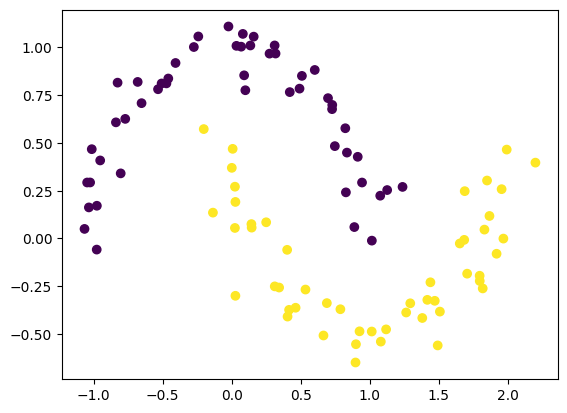

In [ ]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.1, random_state=43)

plt.scatter(X[:, 0], X[:, 1], c=y)


In [ ]:
model= ANN(2)
print(model)
print(model.l1.weights)
print(model.l2.weights)


ANN(2)
[[Value(W00 ,data=1.5152999555401199, grad = 0), Value(W01 ,data=-1.4626646747048497, grad = 0)], [Value(W10 ,data=-1.1138601960556151, grad = 0), Value(W11 ,data=0.3493993706227531, grad = 0)]]
[[Value(W00 ,data=-2.3789930656771197, grad = 0), Value(W01 ,data=-1.3664772786508923, grad = 0)]]


In [ ]:
i=0
y_pred = []
for (x,y_) in zip(X,y):

  x = to_value(x)
  y_ = Value(y_)

  out = model.forward(x)
  pred = 0 if out[0].data < 0 else 1
  print(f"{i}  x = {x}, y = {y_},\n out = {out[0].data}  pred = {pred} ")
  i+=1
  y_pred.append(pred)

0  x = [Value(val ,data=0.135923328444994, grad = 0), Value(val ,data=1.0100807296040162, grad = 0)], y = Value(val ,data=0, grad = 0),
 out = 0.9838712358306396  pred = 1 
1  x = [Value(val ,data=1.0769691002675532, grad = 0), Value(val ,data=0.22374450541184898, grad = 0)], y = Value(val ,data=0, grad = 0),
 out = -0.8134727813402307  pred = 0 
2  x = [Value(val ,data=0.5094682552094713, grad = 0), Value(val ,data=0.8509653558845094, grad = 0)], y = Value(val ,data=0, grad = 0),
 out = 0.5806420100764934  pred = 1 
3  x = [Value(val ,data=0.16012046352693463, grad = 0), Value(val ,data=1.0563349741787025, grad = 0)], y = Value(val ,data=0, grad = 0),
 out = 0.985461782405649  pred = 1 
4  x = [Value(val ,data=0.14351734800531202, grad = 0), Value(val ,data=0.0751442141315464, grad = 0)], y = Value(val ,data=1, grad = 0),
 out = -0.39234539925823514  pred = 0 
5  x = [Value(val ,data=1.685484414189378, grad = 0), Value(val ,data=-0.00737555639582135, grad = 0)], y = Value(val ,data=1,

In [ ]:
print(y_pred)

[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0]


In [ ]:
## Accuracy of initial predictions (untrained model)
from sklearn.metrics import accuracy_score
accuracy_score(y, y_pred)

0.2

In [ ]:
model.print_weights() # Before training

[Value(W00 ,data=1.5152999555401199, grad = 0), Value(W01 ,data=-1.4626646747048497, grad = 0)]
[Value(W10 ,data=-1.1138601960556151, grad = 0), Value(W11 ,data=0.3493993706227531, grad = 0)]
[Value(W00 ,data=-2.3789930656771197, grad = 0), Value(W01 ,data=-1.3664772786508923, grad = 0)]


In [ ]:
model.print_weights() # After training

[Value(W00 ,data=1.5034747677262772, grad = 0), Value(W01 ,data=-1.422544237453306, grad = 0)]
[Value(W10 ,data=-1.1146536104240317, grad = 0), Value(W11 ,data=0.34997498711839586, grad = 0)]
[Value(W00 ,data=-1.7652031073113648, grad = 0), Value(W01 ,data=-1.988272014181469, grad = 0)]


In [ ]:
epochs = 1

for epoch in range(epochs):
  for (x,y_) in zip(X,y):
    x = to_value(x)
    y_ = Value(y_)
    out = model.forward(x)

    loss = SELoss(out[0],y_)
    loss.backwardpass()
    model.update()
    loss.zero_grad()

In [ ]:
i=0
y_pred = []
for (x,y_) in zip(X,y):

  x = to_value(x)
  y_ = Value(y_)

  out = model.forward(x)
  pred = 0 if out[0].data < 0 else 1
  print(f"{i}  x = {x}, y = {y_},\n out = {out[0].data}  pred = {pred} ")
  i+=1
  y_pred.append(pred)

print(f"Accuracy after one epoch of training = {accuracy_score(y_pred,y)}")

0  x = [Value(val ,data=0.135923328444994, grad = 0), Value(val ,data=1.0100807296040162, grad = 0)], y = Value(val ,data=0, grad = 0),
 out = 0.9975835319947254  pred = 1 
1  x = [Value(val ,data=1.0769691002675532, grad = 0), Value(val ,data=0.22374450541184898, grad = 0)], y = Value(val ,data=0, grad = 0),
 out = 0.609242817857847  pred = 1 
2  x = [Value(val ,data=0.5094682552094713, grad = 0), Value(val ,data=0.8509653558845094, grad = 0)], y = Value(val ,data=0, grad = 0),
 out = 0.9706491752254292  pred = 1 
3  x = [Value(val ,data=0.16012046352693463, grad = 0), Value(val ,data=1.0563349741787025, grad = 0)], y = Value(val ,data=0, grad = 0),
 out = 0.9977502961316864  pred = 1 
4  x = [Value(val ,data=0.14351734800531202, grad = 0), Value(val ,data=0.0751442141315464, grad = 0)], y = Value(val ,data=1, grad = 0),
 out = 0.8624481698771556  pred = 1 
5  x = [Value(val ,data=1.685484414189378, grad = 0), Value(val ,data=-0.00737555639582135, grad = 0)], y = Value(val ,data=1, gr

Here, we can see that the accuracy has increased after 1 epoch of training !

In [ ]:
print(X[0], y[0])

[0.13592333 1.01008073] 0


In [ ]:
x = to_value(X[0])
# print(x)
y_ = Value(y[0])
# print(f"Y = {y_}")


# print(model.l1.weights)
# print(model.l2.weights)

out = model.forward(x)



# print(out[0])

loss = SELoss(out[0],y_)
# print(loss)

loss.backwardpass()

print("-"*30, "After Backwardpass", '-'*30)

# print(f"loss  = {loss}")
# print(f"{out[0]}")

print("Updated_weighs")
model.update()
# print(model.l1.weights)
# print(model.l2.weights)


print("After Zero Grad")
loss.zero_grad()
# print(f"loss  = {loss}")
# print(f"{out[0]}")
# print(model.l1.weights)
# print(model.l2.weights)


Forwarding layer Layer(2),[Value(W00 * val + W01 * val + B0 ,data=1.3773081230453816, grad = 0), Value(W10 * val + W11 * val + B1 ,data=0.08213685863354125, grad = 0)]
TanH Layer(2),[Value(tanh(W00 * val + W01 * val + B0) ,data=0.8803470584972214, grad = 0), Value(tanh(W10 * val + W11 * val + B1) ,data=0.08195264462728366, grad = 0)]
Forwarding layer Layer(2),[Value(W00 * tanh(W00 * val + W01 * val + B0) + W01 * tanh(W10 * val + W11 * val + B1) + B0 ,data=0.4582792360687133, grad = 0)]
Tanh of Layer(1),[Value(tanh(W00 * tanh(W00 * val + W01 * val + B0) + W01 * tanh(W10 * val + W11 * val + B1) + B0) ,data=0.4286807040414345, grad = 0)]
a = Value(2 ,data=2, grad = 0)
a = Value(2 ,data=2, grad = 0)
inside lossfunc Value((tanh(W00 * tanh(W00 * val + W01 * val + B0) + W01 * tanh(W10 * val + W11 * val + B1) + B0) - val) ** 2 ,data=0.18376714601745994, grad = 0)

------------------------------ After Backwardpass ------------------------------
Updated_weighs
After Zero Grad


In [ ]:
from sklearn.metrics import accuracy_score



<function Value.__mul__.<locals>.backward at 0x7da999f5fac0>


### Final Training

#### Data

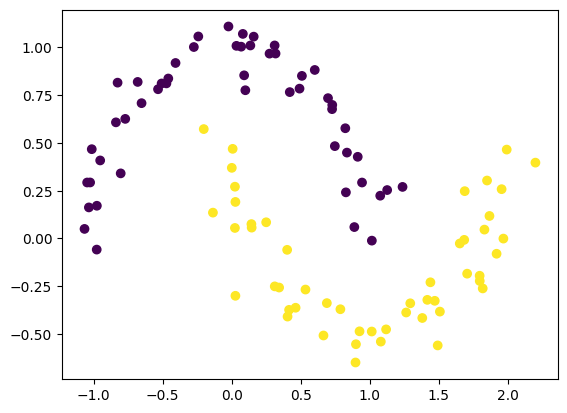

In [ ]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.1, random_state=43)

plt.scatter(X[:, 0], X[:, 1], c=y)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(80, 2)
(20, 2)


In [ ]:
def predict(model, X):
  y_pred = []
  for x in X:
    x = to_value(x)
    out = model.forward(x)
    pred = 0 if out[0].data < 0 else 1 # The forward function here returns a probablity value,(as tanh is the activation), using binary seperators
    y_pred.append(pred)

  return y_pred

#### Model1

In [ ]:
model = ANN(2)

In [ ]:
from sklearn.metrics import accuracy_score
model.print_weights()
y_pred = predict(model, X_test)
print(f"Accuracy before training = {accuracy_score(y_pred,y_test)}")

[Value(W00 ,data=-0.028112819518567006, grad = 0), Value(W01 ,data=-0.8010588885609742, grad = 0)]
[Value(W10 ,data=-1.696316745567487, grad = 0), Value(W11 ,data=-1.0154331853946246, grad = 0)]
[Value(W00 ,data=-2.8843182875106863, grad = 0), Value(W01 ,data=0.8806111311071094, grad = 0)]
Accuracy before training = 0.45


After training for n epochs, the accuracy of the model froze to 0.5, after decreasing consistently after trainng

In [ ]:
## Training
## This updates model's weights, so if we run this multople times, the updates stack up, ie running it twice is as good as 20 epochs of SGD
epochs = 50
history1  = []
loss1 = []

for epoch in range(epochs):
  print(f"Training epoch {epoch}")
  for (x,y_) in zip(X_train,y_train):
    x = to_value(x)
    y_ = Value(y_) # Converssion to custom values
    out = model.forward(x)

    loss = SELoss(out[0],y_)
    # model.print_weights()
    y_pred = predict(model, X_test)
    # print(f"Accuracy before training = {accuracy_score(y_pred,y)}")
    loss1.append(loss.data)
    history1.append(accuracy_score(y_pred,y_test))

    loss.backwardpass() # Squared Error loss
    model.update() # Stochiastic gradient descent, as updating at every step
    loss.zero_grad()
  if epoch %5==0:
      model.print_weights()
      y_pred = predict(model, X_test)
      print(f"Accuracy before training = {accuracy_score(y_pred,y_test)}")



Training epoch 0
[Value(W00 ,data=-0.07104883177962262, grad = 0), Value(W01 ,data=-0.7711441803119576, grad = 0)]
[Value(W10 ,data=-1.6918937204451554, grad = 0), Value(W11 ,data=-1.0224417229865055, grad = 0)]
[Value(W00 ,data=-2.869563609890383, grad = 0), Value(W01 ,data=0.8858540973830744, grad = 0)]
Accuracy before training = 0.45
Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
[Value(W00 ,data=-0.16899334792140444, grad = 0), Value(W01 ,data=-0.6494674189015566, grad = 0)]
[Value(W10 ,data=-1.6739221339551273, grad = 0), Value(W11 ,data=-1.0645484010373722, grad = 0)]
[Value(W00 ,data=-2.7324400183444633, grad = 0), Value(W01 ,data=0.987071987061524, grad = 0)]
Accuracy before training = 0.45
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9
Training epoch 10
[Value(W00 ,data=-0.35997610958387394, grad = 0), Value(W01 ,data=-0.3489957697341342, grad = 0)]
[Value(W10 ,data=-1.6033250164304758, grad = 0), Value(W11 ,data=-1.19

In [ ]:
print(loss1)

[0.03641541176624367, 0.016770860788021803, 0.9867097362827629, 0.9338497856513062, 0.9911136313147525, 0.9346296612104036, 0.992838656874319, 0.026281137540287863, 0.031343870576823196, 0.9779329341600232, 0.9266031839304963, 0.9418119703634437, 0.018991478977229158, 0.030797245475425703, 0.009548451915626201, 0.0005054841750249292, 0.003339819789144348, 0.8929365649999476, 0.990761686208274, 0.03186007541252523, 0.8882103517511694, 0.00735809099132729, 0.0030696998017786968, 0.940455912521008, 0.01605124439945696, 0.9936560087629563, 0.9819401927884173, 0.9053553056021006, 0.00022576359101681735, 0.9070768521682977, 0.0043392537697686875, 0.0005151282428330781, 0.9399989406543965, 0.008913747336166372, 0.003800511715755757, 0.9467037590569489, 0.9906257677345193, 0.9946669204145406, 0.0067726694652456, 0.9953408125763928, 0.9451171663308545, 0.041649449611652005, 0.9438273055771302, 0.019407440219922162, 0.020587388337909438, 0.05448885110547377, 0.058318153089043256, 0.0005313609476

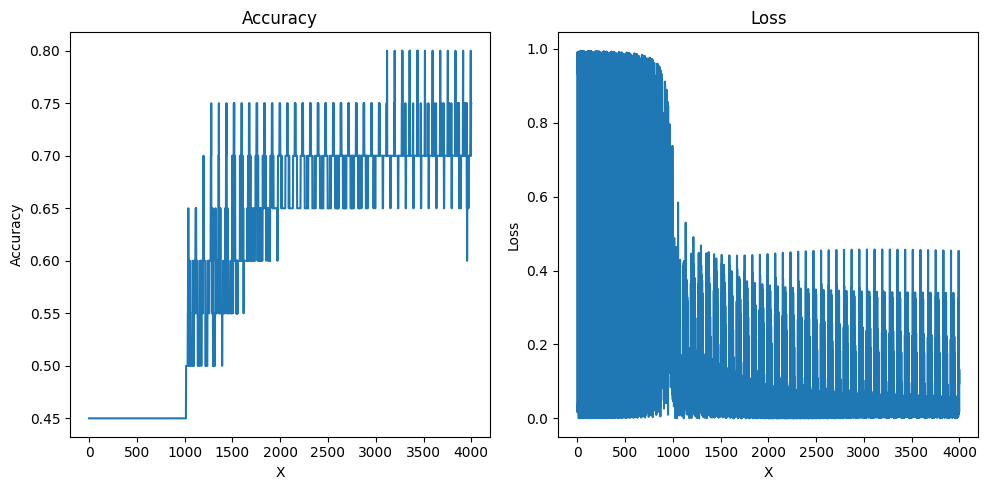

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot accuracy on the first axis
ax[0].plot(history1)
ax[0].set_title('Accuracy')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Accuracy')

# Plot loss on the second axis

ax[1].plot(loss1)
ax[1].set_title('Loss')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Loss')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot

plt.show()

**1 Hidden Layer, LR = 0.01**

Here, we can see constant oscillations in accuracy and loss but they did manange to converge with a decent accuracy and loss

#### Model2

Trying using the same model but with different learning rate

In [ ]:
model2 = ANN(2, lr=0.1)


In [ ]:
# model2.print_weights()
# y_pred = predict(model2, X)
# print(f"Accuracy after training 0 epochs = {accuracy_score(y_pred,y)}")

In [ ]:
x = to_value(X[0])
y_ = Value(y[0])

model2.print_weights()

out = model2.forward(x)
print(out[0])

loss = SELoss(out[0], y_)

print(loss)
print(f"{out[0]}")

loss.backwardpass()
print(f"loss = {loss}")



model2.update()

model2.print_weights()

loss.zero_grad()
print(loss)
model2.print_weights()



model2.print_weights()

out = model2.forward(x)
print(out[0])

loss = SELoss(out[0], y_)

print(loss)
print(f"{out[0]}")

loss.backwardpass()
print(f"loss = {loss}")



model2.update()

model2.print_weights()

loss.zero_grad()
print(loss)
model2.print_weights()


[Value(W00 ,data=0.007533941527721835, grad = 0), Value(W01 ,data=-1.2405887195153305, grad = 0)]
[Value(W10 ,data=-1.9907668238827843, grad = 0), Value(W11 ,data=-0.23304507874545363, grad = 0)]
[Value(W00 ,data=-2.0859033503014603, grad = 0), Value(W01 ,data=-0.5706851463244338, grad = 0)]
Value(tanh(W00 * tanh(W00 * val + W01 * val + B0) + W01 * tanh(W10 * val + W11 * val + B1) + B0) ,data=-0.7466664076362436, grad = 0)
Value((tanh(W00 * tanh(W00 * val + W01 * val + B0) + W01 * tanh(W10 * val + W11 * val + B1) + B0) - val) ** 2 ,data=0.5575107242924131, grad = 0)
Value(tanh(W00 * tanh(W00 * val + W01 * val + B0) + W01 * tanh(W10 * val + W11 * val + B1) + B0) ,data=-0.7466664076362436, grad = 0)
loss = Value((tanh(W00 * tanh(W00 * val + W01 * val + B0) + W01 * tanh(W10 * val + W11 * val + B1) + B0) - val) ** 2 ,data=0.5575107242924131, grad = 1)
[Value(W00 ,data=-0.008976229581743093, grad = 0.16510171109464927), Value(W01 ,data=-1.3632799887104063, grad = 1.2269126919507596)]
[Value

In [ ]:
from sklearn.metrics import accuracy_score
## Training
## This updates model's weights(?), so if we run this multople times, the updates stack up, ie running it twice is as good as 20 epochs of SGD
epochs = 50
history2  = []
loss2 = []
training_accuracy2=[]

for epoch in range(epochs):
  print(f"Training epoch {epoch}")
  for (x,y_) in zip(X_train,y_train):
    # print(f"training for [{x}, {y_}]")
    x = to_value(x)
    y_ = Value(y_) # Converssion to custom values

    out = model2.forward(x)

    loss = SELoss(out[0], y_)
    # print(loss)
    # model.print_weights()
    y_pred = predict(model2, X_test)

    y_pred_train = predict(model2, X_train)

    # print(f"Accuracy before training = {accuracy_score(y_pred,y)}")
    loss2.append(loss.data)
    atest = accuracy_score(y_pred,y_test)
    atrain = accuracy_score(y_pred_train,y_train)
    history2.append(atest)
    training_accuracy2.append(atrain)
    # print(f"appended {atrain} and {atest}")

    loss.backwardpass() # Squared Error loss
    # print(loss)
    # print(loss.children)

    model2.update() # Stochiastic gradient descent, as updating at every step

    loss.zero_grad()
  # if epoch %5==0:
    # model.print_weights()
    # y_pred = predict(model2, X_test)
    # print(f"Accuracy= {accuracy_score(y_pred,y_test)}")


Training epoch 0
Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9
Training epoch 10
Training epoch 11
Training epoch 12
Training epoch 13
Training epoch 14
Training epoch 15
Training epoch 16
Training epoch 17
Training epoch 18
Training epoch 19
Training epoch 20
Training epoch 21
Training epoch 22
Training epoch 23
Training epoch 24
Training epoch 25
Training epoch 26
Training epoch 27
Training epoch 28
Training epoch 29
Training epoch 30
Training epoch 31
Training epoch 32
Training epoch 33
Training epoch 34
Training epoch 35
Training epoch 36
Training epoch 37
Training epoch 38
Training epoch 39
Training epoch 40
Training epoch 41
Training epoch 42
Training epoch 43
Training epoch 44
Training epoch 45
Training epoch 46
Training epoch 47
Training epoch 48
Training epoch 49


In [ ]:
print(history2)

[0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.4

In [ ]:
print(loss2)

[0.019740876244121023, 0.013284020159845374, 0.9870781368323049, 0.9745323161409304, 0.9840087162171672, 0.9703090301354858, 0.9472975257524666, 0.023764265757914318, 0.015574274938407826, 0.9886031554832508, 0.9475856446976323, 0.9844873050646026, 0.01284620928577031, 0.015041187456885985, 0.010527326760848403, 0.00012179702370291828, 0.0034035194870523267, 0.8748502822885612, 0.9838731243478677, 0.038226589168667516, 0.875742099393079, 0.013623201576082634, 0.011892302095867405, 0.9816015785013047, 0.013765009762231472, 0.9807777266160034, 0.9852474893141215, 0.8782757948360045, 0.0005282428727047002, 0.8803375078042753, 0.012654869418876101, 0.0002885780597077807, 0.9788708550033656, 0.01851727822029224, 0.015454822135152634, 0.9849670015840989, 0.93641961649939, 0.9487968753619257, 0.01506398683452147, 0.9557728014725325, 0.9778816620633427, 0.020297473723637775, 0.9820742773399562, 0.016853744965534732, 0.014245305949413733, 0.026524143739783894, 0.03595729628607793, 0.00117240989

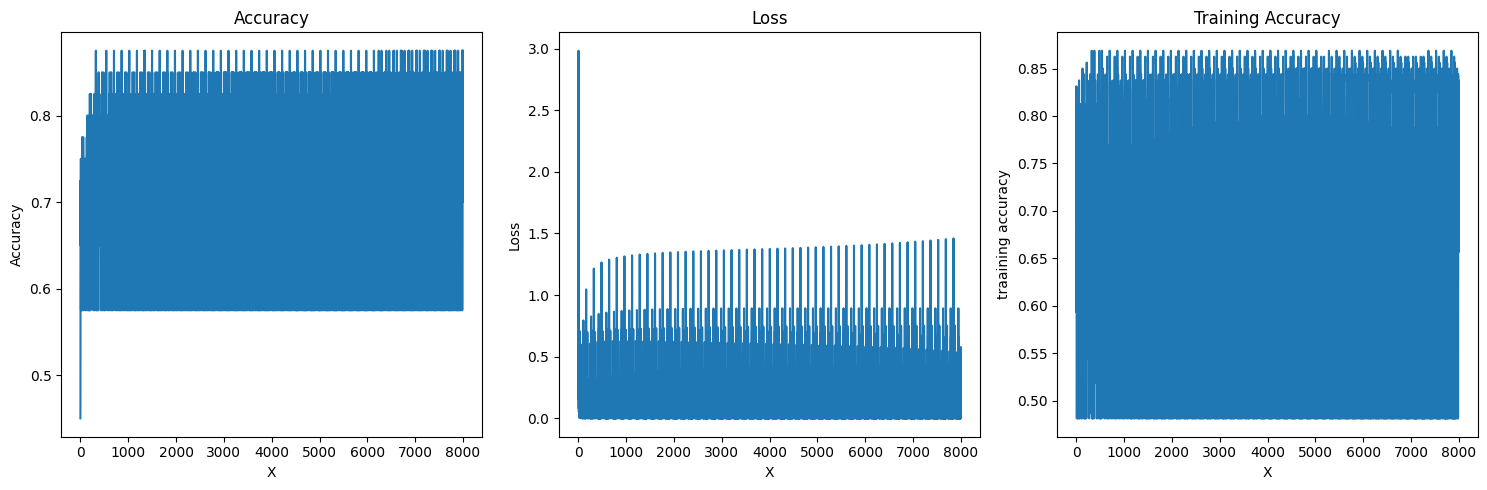

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 5))


# Plot accuracy on the first axis
ax[0].plot(history2)
ax[0].set_title('Accuracy')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Accuracy')


# Plot loss on the second axis

ax[1].plot(loss2)
ax[1].set_title('Loss')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Loss')

# Plot loss on the second axis

ax[2].plot(training_accuracy2)
ax[2].set_title('Training Accuracy')
ax[2].set_xlabel('X')
ax[2].set_ylabel('traaining accuracy')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot

plt.show()

**1 hidden layer, lr = 0.1**

Here, we can see that with higher learning rate, the loss has decreased significantly over the same no of epochs and accuracy has increased significantly (while its still very noisy due to SGD over 100 datapoints and 50 epochs), This is with 1 hidden layer, and lr = 0.1

#### Test using pytorch

In [ ]:
import torch
import torch.nn as nn

class torchANN(nn.Sequential):
    def __init__(self, input_size, hidden_size, output_size):
        super(torchANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x

In [ ]:
torchmodel = torchANN(2, 2, 1)
optimizer = torch.optim.SGD(torchmodel.parameters(), lr=0.01)
epochs = 1
torchloss = []
torchhistory = []

for epoch in range(epochs):
  print(f"Training epoch {epoch}")
  for (x,y_) in zip(X_train,y_train):
    x = torch.tensor(x, dtype=torch.float32)
    y_ = torch.tensor(y_, dtype=torch.float32)
    out = torchmodel(x)
    loss = torch.nn.functional.mse_loss(out, y_)
    torchloss.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Training epoch 0


<ipython-input-135-2e050e61f962>:13: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(out, y_)


In [ ]:
print(torchloss)

[tensor(2.0353, grad_fn=<MseLossBackward0>), tensor(1.9580, grad_fn=<MseLossBackward0>), tensor(0.1083, grad_fn=<MseLossBackward0>), tensor(0.1041, grad_fn=<MseLossBackward0>), tensor(0.1003, grad_fn=<MseLossBackward0>), tensor(0.0932, grad_fn=<MseLossBackward0>), tensor(0.1164, grad_fn=<MseLossBackward0>), tensor(1.7919, grad_fn=<MseLossBackward0>), tensor(1.7190, grad_fn=<MseLossBackward0>), tensor(0.0497, grad_fn=<MseLossBackward0>), tensor(0.0524, grad_fn=<MseLossBackward0>), tensor(0.0430, grad_fn=<MseLossBackward0>), tensor(1.5910, grad_fn=<MseLossBackward0>), tensor(1.5133, grad_fn=<MseLossBackward0>), tensor(1.4058, grad_fn=<MseLossBackward0>), tensor(1.2864, grad_fn=<MseLossBackward0>), tensor(1.2751, grad_fn=<MseLossBackward0>), tensor(0.0048, grad_fn=<MseLossBackward0>), tensor(0.0033, grad_fn=<MseLossBackward0>), tensor(1.2627, grad_fn=<MseLossBackward0>), tensor(0.0015, grad_fn=<MseLossBackward0>), tensor(1.1017, grad_fn=<MseLossBackward0>), tensor(0.9987, grad_fn=<MseLoss

Text(0, 0.5, 'Loss')

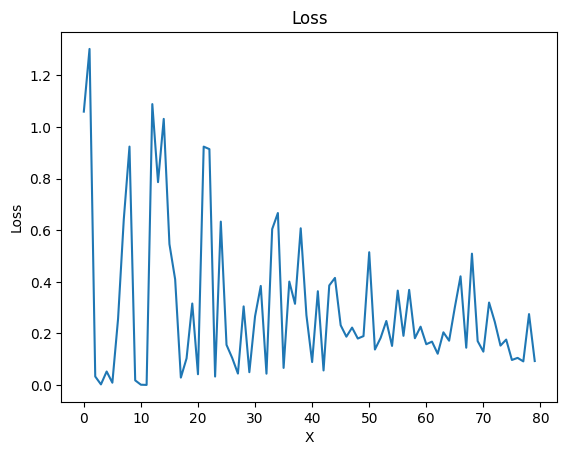

In [ ]:
import matplotlib.pyplot as plt
# Plot loss on the second axis
tl = [x.detach().numpy() for x in torchloss]

plt.plot(tl)
plt.title('Loss')
plt.xlabel('X')
plt.ylabel('Loss')

### Adding a Hidden Layer

Trying with a better model and using different train and test sets

In [ ]:
class ANN2:

  def __init__(self, n_inputs, lr=0.01):
    self.lr = lr
    self.l1 = Layer(n_inputs, 2, index=0)
    self.l2 = Layer(2, 2, index=1)
    self.l3 = Layer(2, 1, index=2) # Adding an extra hidden layer
    self.layers = [self.l1, self.l2,self.l3]

  def forward(self, X):


    X = self.l1.forward(X)
    # print(f"Forwarding layer {self.l1},{X}")
    X = [x.tanh() for x in X]
    # print(f"TanH {self.l1},{X}")

    X = self.l2.forward(X)
    # print(f"Forwarding layer {self.l1},{X}")
    X = [x.tanh() for x in X]
      # print(f"Tanh of {self.l2},{X}")
    X = self.l3.forward(X)
    # print(f"Forwarding layer {self.l1},{X}")
    X = [x.tanh() for x in X]
    # print(f"Tanh of {self.l3},{X}")
    return X

  def update(self):
    for layer in self.layers:
      layer.update(self.lr)

  def print_weights(self):
    for layer in self.layers:
      for neuron in layer.neurons:
        print(neuron.weights)

  def __repr__(self):
    return f"ANN({len(self.layers)})"

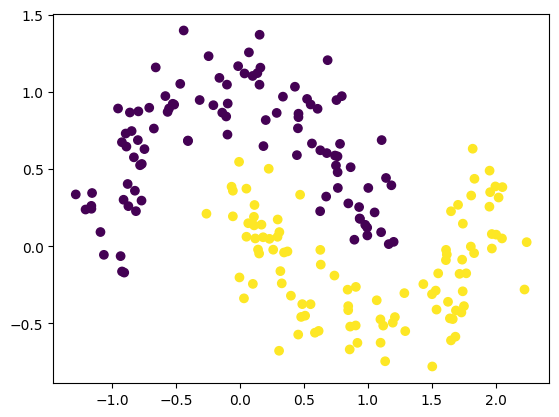

In [ ]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=200, noise=0.16, random_state=43) # Increasing data as well as noist

plt.scatter(X[:, 0], X[:, 1], c=y)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)


In [ ]:
print(X_train.shape)
print(X_test.shape)

(160, 2)
(40, 2)


#### Model3

In [ ]:
model3 = ANN2(2)

In [ ]:
model3.print_weights()
y_pred = predict(model3, X)
print(f"Accuracy after training 0 epochs = {accuracy_score(y_pred,y)}")

[Value(W00 ,data=0.8302315383900628, grad = 0), Value(W01 ,data=0.1874378454623751, grad = 0)]
[Value(W10 ,data=-0.08666990290737096, grad = 0), Value(W11 ,data=0.5534157338129823, grad = 0)]
[Value(W00 ,data=-0.9890525424680023, grad = 0), Value(W01 ,data=0.15436083377366094, grad = 0)]
[Value(W10 ,data=-0.7913315761145576, grad = 0), Value(W11 ,data=-0.6758267890278972, grad = 0)]
[Value(W00 ,data=-0.9084028058548009, grad = 0), Value(W01 ,data=-1.515576407586001, grad = 0)]
Accuracy after training 0 epochs = 0.5


In [ ]:
## Training
## This updates model's weights, so if we run this multople times, the updates stack up, ie running it twice is as good as 20 epochs of SGD
epochs = 50
history3  = []
loss3= []

for epoch in range(epochs):
  print(f"Training epoch {epoch}")
  for (x,y_) in zip(X_train,y_train):
    x = to_value(x)
    y_ = Value(y_) # Converssion to custom values
    out = model3.forward(x)

    loss = SELoss(out[0],y_)
    # model.print_weights()
    y_pred = predict(model3, X_test)
    # print(f"Accuracy before training = {accuracy_score(y_pred,y_test)}")
    loss3.append(loss.data)
    history3.append(accuracy_score(y_pred,y_test))

    loss.backwardpass() # Squared Error loss

    model3.update() # Stochiastic gradient descent, as updating at every step

    loss.zero_grad()
  if epoch %5==0:
      model.print_weights()
      y_pred = predict(model3, X_test)
      print(f"Accuracy before training = {accuracy_score(y_pred,y_test)}")


Training epoch 0
[Value(W00 ,data=-0.5282082340081998, grad = 0), Value(W01 ,data=1.3616055499617818, grad = 0)]
[Value(W10 ,data=-1.0789748926033238, grad = 0), Value(W11 ,data=0.5153925730615416, grad = 0)]
[Value(W00 ,data=-1.3312703868577174, grad = 0), Value(W01 ,data=0.4200402886754789, grad = 0)]
Accuracy before training = 0.625
Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
[Value(W00 ,data=-0.5282082340081998, grad = 0), Value(W01 ,data=1.3616055499617818, grad = 0)]
[Value(W10 ,data=-1.0789748926033238, grad = 0), Value(W11 ,data=0.5153925730615416, grad = 0)]
[Value(W00 ,data=-1.3312703868577174, grad = 0), Value(W01 ,data=0.4200402886754789, grad = 0)]
Accuracy before training = 0.7
Training epoch 6
Training epoch 7
Training epoch 8
Training epoch 9
Training epoch 10
[Value(W00 ,data=-0.5282082340081998, grad = 0), Value(W01 ,data=1.3616055499617818, grad = 0)]
[Value(W10 ,data=-1.0789748926033238, grad = 0), Value(W11 ,data=0.515392573

In [ ]:
print(history3)

[0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.425, 0.45, 0.475, 0.475, 0.5, 0.525, 0.475, 0.475, 0.475, 0.475, 0.425, 0.475, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.525, 0.525, 0.525, 0.5, 0.525, 0.525, 0.525, 0.525, 0.525, 0.575, 0.6, 0.625, 0.625, 0.625, 0.65, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.7, 0.675, 0.675, 0.675, 0.7, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.65, 0.625, 0.65, 0.625, 0.625, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.675, 0.675, 0.675, 0.675, 0.675, 0.625, 0.625, 0.625, 0.675, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.65, 0.675, 0.675, 0.6

In [ ]:
print(loss3)

[0.6550797587466815, 0.48303499411061324, 3.4388722270547407, 0.973781169400396, 3.824125743577417, 0.9657161408388554, 3.821941524340468, 3.2864458051328227, 0.3568635242392011, 1.0797557735455816, 3.555504020096087, 3.481674816486447, 0.581117604952847, 3.08966171003297, 0.0018355027219449898, 0.9195447703191135, 0.058582059582757494, 0.8512820688196266, 0.26384776197439685, 1.509504903947941, 2.5989068213565383, 0.9400264609101615, 0.1328579451078249, 0.1710220353985214, 0.05032273479103331, 0.5839405593177174, 0.03530054751883273, 0.33957661679873935, 0.9215015222457427, 0.5878430149140547, 0.5192937828896972, 0.5703378976274223, 0.1302183434735947, 0.03627876625282342, 0.47209209711539807, 0.43220099889263913, 0.2889050252738278, 0.9787190976815913, 0.5249858710902034, 0.9788345489561885, 0.8169152857201282, 0.0792471808523177, 0.05646947766495466, 0.6658974211770394, 0.3538739852141566, 0.02306864140796621, 0.034833942383142386, 0.026705306771409948, 0.8265554927148209, 0.1843675

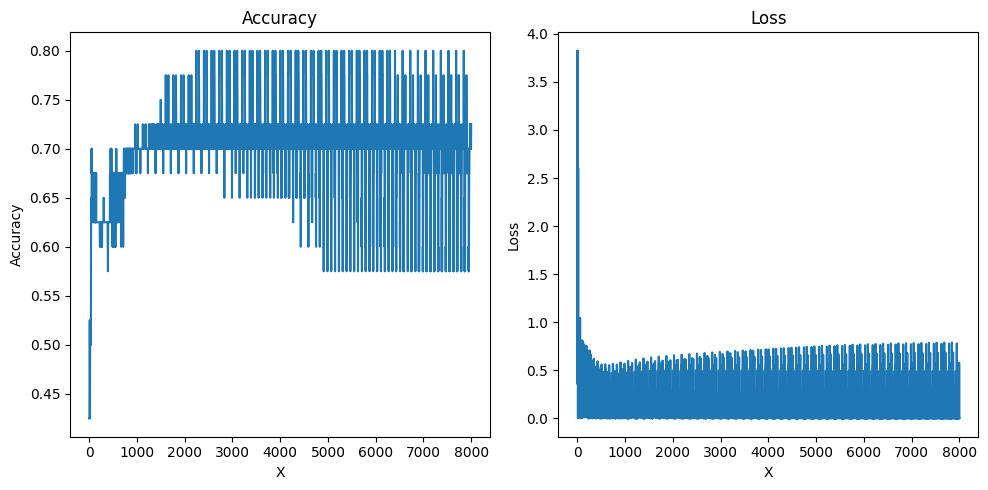

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot accuracy on the first axis
ax[0].plot(history3)
ax[0].set_title('Accuracy')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Accuracy')

# Plot loss on the second axis

ax[1].plot(loss3)
ax[1].set_title('Loss')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Loss')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot

plt.show()

**2 Hidden Layers, lr = 0.01**

Just by adding 1 more layer, we can see that the oscillations in loss have become much more less noisier and converging to zero over increasing X, similarly the accuracy is also increasing but only upto a point.

#### Model 4

In [ ]:
model4 = ANN2(2, lr=0.000001) # trying with very low LR to see if oscillations stop

epochs = 50
history4 = []
loss4 = []

## Training
## This updates model's weights, so if we run this multople times, the updates stack up, ie running it twice is as good as 20 epochs of SGD


for epoch in range(epochs):
  print(f"Training epoch {epoch}")
  for (x,y_) in zip(X_train,y_train):
    x = to_value(x)
    y_ = Value(y_) # Converssion to custom values
    out = model4.forward(x)

    loss = SELoss(out[0],y_)
    # model.print_weights()
    y_pred = predict(model4, X_test)
    # print(f"Accuracy before training = {accuracy_score(y_pred,y)}")
    loss4.append(loss.data)
    history4.append(accuracy_score(y_pred,y_test))

    loss.backwardpass() # Squared Error loss
    model4.update() # Stochiastic gradient descent, as updating at every step


    loss.zero_grad()
  if epoch %5==0:
      model4.print_weights()
      y_pred = predict(model4, X_test)
      print(f"Accuracy before training = {accuracy_score(y_pred,y_test)}")


Training epoch 0
[Value(W00 ,data=-1.1129328106220004, grad = 0), Value(W01 ,data=-0.620998397824552, grad = 0)]
[Value(W10 ,data=-0.6231641742430468, grad = 0), Value(W11 ,data=0.7370304992527852, grad = 0)]
[Value(W00 ,data=0.871316866133526, grad = 0), Value(W01 ,data=-1.1062388099395937, grad = 0)]
[Value(W10 ,data=0.5456574822261446, grad = 0), Value(W11 ,data=1.2031736494458831, grad = 0)]
[Value(W00 ,data=-1.0611951418989471, grad = 0), Value(W01 ,data=-2.8028544955453127, grad = 0)]
Accuracy before training = 0.625
Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
[Value(W00 ,data=-1.1130466992421244, grad = 0), Value(W01 ,data=-0.6209470583947039, grad = 0)]
[Value(W10 ,data=-0.6232604562172229, grad = 0), Value(W11 ,data=0.7370104798411341, grad = 0)]
[Value(W00 ,data=0.8713154639171347, grad = 0), Value(W01 ,data=-1.1061958738403808, grad = 0)]
[Value(W10 ,data=0.5456811490433922, grad = 0), Value(W11 ,data=1.2033569713280545, grad = 0)]
[V

In [ ]:
print(history4)
print(loss4)

[0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575, 0.575

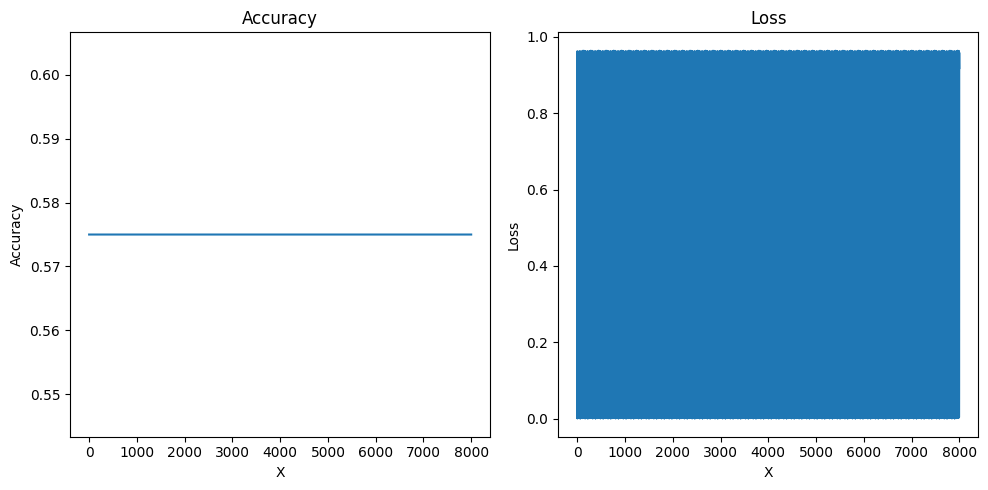

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot accuracy on the first axis
ax[0].plot(history4)
ax[0].set_title('Accuracy')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Accuracy')

# Plot loss on the second axis

ax[1].plot(loss4)
ax[1].set_title('Loss')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Loss')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot

plt.show()

**2 Hidden layers, lr = 0.000001**

Here, we can see with very less learning rate, the accuracy almost seems constant, and loss very high always with high oscillations

#### Model5
Trying with higher learning rate

In [ ]:
model5 = ANN2(2, lr=0.1) # trying with very low LR to see if oscillations stop

epochs = 50
history5 = []
loss5 = []

## Training
## This updates model's weights, so if we run this multople times, the updates stack up, ie running it twice is as good as 20 epochs of SGD


for epoch in range(epochs):
  print(f"Training epoch {epoch}")
  for (x,y_) in zip(X_train,y_train):
    x = to_value(x)
    y_ = Value(y_) # Converssion to custom values
    out = model5.forward(x)

    loss = SELoss(out[0],y_)
    # model.print_weights()
    y_pred = predict(model5, X_test)
    # print(f"Accuracy before training = {accuracy_score(y_pred,y)}")
    loss5.append(loss.data)
    history5.append(accuracy_score(y_pred,y_test))

    loss.backwardpass() # Squared Error loss
    model5.update() # Stochiastic gradient descent, as updating at every step


    loss.zero_grad()
  if epoch %5==0:
      model5.print_weights()
      y_pred = predict(model5, X_test)
      print(f"Accuracy before training = {accuracy_score(y_pred,y_test)}")

Training epoch 0
[Value(W00 ,data=-0.7877167808597567, grad = 0), Value(W01 ,data=0.33422781385929234, grad = 0)]
[Value(W10 ,data=-0.4786431579670317, grad = 0), Value(W11 ,data=-1.795937389263069, grad = 0)]
[Value(W00 ,data=-1.3141455598600424, grad = 0), Value(W01 ,data=-0.6126236825618945, grad = 0)]
[Value(W10 ,data=-1.51581751964022, grad = 0), Value(W11 ,data=1.0300387867395466, grad = 0)]
[Value(W00 ,data=0.10869355638588041, grad = 0), Value(W01 ,data=0.7573583842206979, grad = 0)]
Accuracy before training = 0.675
Training epoch 1
Training epoch 2
Training epoch 3
Training epoch 4
Training epoch 5
[Value(W00 ,data=-0.6338625398629633, grad = 0), Value(W01 ,data=0.9397931844034163, grad = 0)]
[Value(W10 ,data=-0.3222251095153703, grad = 0), Value(W11 ,data=-2.031167323591106, grad = 0)]
[Value(W00 ,data=-1.2499114727404772, grad = 0), Value(W01 ,data=-0.49754542742343577, grad = 0)]
[Value(W10 ,data=-1.7648697695030515, grad = 0), Value(W11 ,data=1.0040377780132408, grad = 0)]

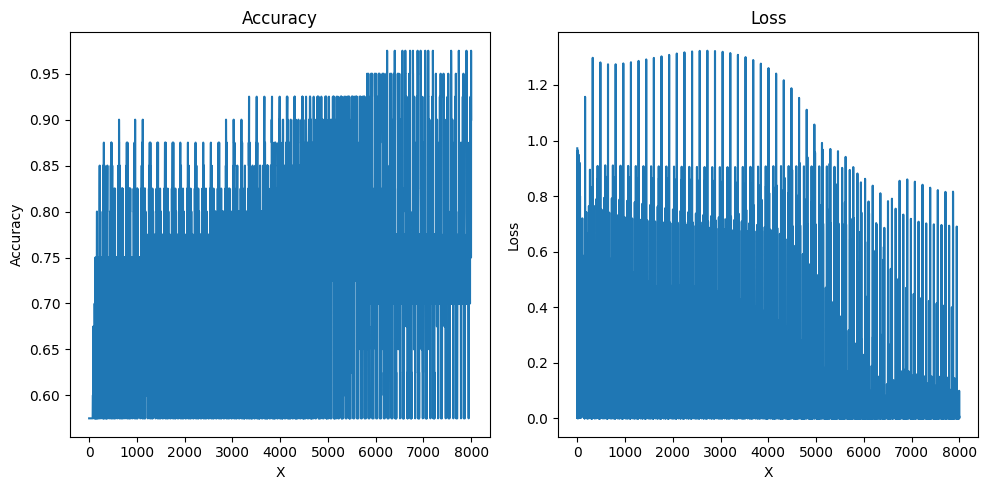

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot accuracy on the first axis
ax[0].plot(history5)
ax[0].set_title('Accuracy')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Accuracy')

# Plot loss on the second axis

ax[1].plot(loss5)
ax[1].set_title('Loss')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Loss')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot

plt.show()

**2 hidden layers, lr = 0.1**

Here, we can see with higher learning rate, and higher no of layers, we can see signs of  overfitting, as the loss reached a low and again increased, while accuracy decreased after reaching a high as well.

### **Conclusion**
This approach works well and on expected lines, for stochiastic gradinent descent giving good accuracy and minimizing loss ;however, it still needs furhter modifications and optimization to implement batch gradient descent successfully, as it does no support vectorization and Tensors as in Sophisticated libraries like PyTorch and Tensorflow.

If we try to implement batch, we need to sum up all the losses in 1 epoch before calling backward, this would require the value add operation, thus, if we backwardpass() the total loss, the graph would contain all the individual losses as well as children this would inturn lead to the same no of weight updates and even additional problems. Hence it is a limitation of above algorithm